In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import *
from sklearn.metrics import classification_report
import joblib
import os
from lightning import seed_everything
from utils import SEED
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from lazy_clf import LazyClassifier
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

/home/miguel/miniconda3/envs/sum/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Methods

In [3]:
def set_seed(seed=SEED):
    seed_everything(seed)

# Load dataset from pickle file
def read_pickle(filename: str) -> pd.DataFrame:
    with open(filename, 'rb') as f:
        return pd.DataFrame(pickle.load(f))

# Perform t-SNE dimensionality reduction
def apply_tsne(dataset_train):
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(dataset_train["sample"])-1), n_iter=1000)
    return tsne.fit_transform(np.array(dataset_train["sample"].to_list()))

def apply_tsne_to_numpy(X):
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(X)-1), n_iter=1000)
    return tsne.fit_transform(X)

# Plot t-SNE scatter plot
def plot_tsne(X_2d, labels):
    colors = ['red', 'blue']
    plt.figure(figsize=(8, 6))
    for i in range(len(X_2d)):
        plt.scatter(X_2d[i, 0], X_2d[i, 1], color=colors[labels[i]], s=15, alpha=0.7, edgecolor='k')
    plt.legend(['Class 0', 'Class 1'], loc='upper right', fontsize=10, frameon=True)
    plt.title("t-SNE Representation", fontsize=14)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot label distribution as a histogram
def plot_label_distribution(label_counts, title="Distribution of Labels"):
    colors = ['blue', 'red']
    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.index, label_counts.values, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    plt.title(title, fontsize=14)
    plt.xlabel("Labels", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks([0, 1], ['Class 0', 'Class 1'], fontsize=10)
    for i, value in enumerate(label_counts.values):
        plt.text(i, value + 0.5, str(value), ha='center', fontsize=10, color='black')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Balance the dataset by downsampling the majority class
def balance_dataset(dataset_train):
    class_majority = dataset_train[dataset_train['label'] == 0]
    class_minority = dataset_train[dataset_train['label'] == 1]
    class_majority_downsampled = class_majority.sample(n=len(class_minority), random_state=42)
    df_balanced = pd.concat([class_majority_downsampled, class_minority])
    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Train and evaluate models using LazyClassifier
def lazy_classification(X_train, X_test, y_train, y_test):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, _ = clf.fit(X_train, X_test, y_train, y_test)
    return models

def save_predictions_to_csv(predictions, folder=None, filename="clf_models.csv"):
    assert folder is not None, "Please provide a folder to save the predictions."
    predictions_df = pd.DataFrame(predictions)
    file_path = os.path.join(folder, filename)
    predictions_df.to_csv(file_path, index=True, sep=';')
    print(f"Predictions saved to {file_path}")

# Optimize and evaluate models using RandomizedSearchCV
def optimize_models(X_train, y_train, X_test, y_test):
    models = {
        "RandomForest": (RandomForestClassifier(n_jobs=-1), {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False]
        }),
    }
    best_models = {}
    for model_name, (model, param_grid) in models.items():
        print(f"\nOptimizing {model_name}...")
        grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")
        best_models[model_name] = best_model
    return best_models

def stacking(estimators, X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LogisticRegression
    final_estimator = LogisticRegression(max_iter=10000)
    clf = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        verbose=1,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classification report for Stacking Classifier:\n{classification_report(y_test, y_pred)}")
    return clf

# Save the best model to a file
def save_model(best_models, model_name, folder="models"):
    os.makedirs(folder, exist_ok=True)
    if model_name in best_models:
        file_path = os.path.join(folder, f"{model_name}_best_model.pkl")
        joblib.dump(best_models[model_name], file_path)
        print(f"Model {model_name} saved as {file_path}")
    else:
        print(f"Model {model_name} not found in best_models.")

In [4]:
def experiments(X_train, y_train, X_test, y_test, dataset_train_path):
    #X_2d = apply_tsne(df_balanced)
    #plot_tsne(X_2d, df_balanced['label'].to_list())

    models = lazy_classification(X_train, X_test, y_train, y_test)
    folder_to_save = "/".join([f for f in dataset_train_path.split("/")[:-1]])
    save_predictions_to_csv(models, folder=folder_to_save)

    print("#"*50)
    print(models.head(5))

def experiments_stacking(X_train, y_train, X_test, y_test, base_classifiers):
    stacking(base_classifiers, X_train, y_train, X_test, y_test)
    

In [5]:
set_seed()

Seed set to 3407


## Autoencoders

In [63]:
class Autoencoder(pl.LightningModule):

    def __init__(self):
        super(Autoencoder, self).__init__()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def features(self, x):
        encoded = self.encoder(x)
        return encoded

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.MSELoss()(x_hat, x)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.MSELoss()(x_hat, x)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.MSELoss()(x_hat, x)
        self.log('test_loss', loss, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def entropy_loss(X, beta=1.0):

    if X.dim() > 2: # 3D -> 2D
        X = X.reshape(-1, X.size(-1))

    X = X.float()
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    
    # Paso 2: Calcular los eigenvalores como cuadrados de los valores singulares
    eigenvalues = S  # λ_i = σ_i^2
    
    # Paso 3: Determinar el rango k de X (número de eigenvalores no nulos)
    k = torch.sum(eigenvalues > 1e-10).item()  # Contar valores singulares mayores que un umbral
    
    # Seleccionar los k valores propios
    top_eigenvalues = eigenvalues[:k]
    
    # Paso 4: Evaluar el término principal
    term1 = 0.5 * torch.sum(torch.log(1 + beta * top_eigenvalues))
    
    # Paso 5: Evaluar el término adicional
    term2 = (k / 2) * torch.log(torch.tensor(beta))
    
    # Paso 6: Sumar ambos términos
    entropy = term1 + term2
    
    return -entropy

class LinearAutoencoder(Autoencoder):
    def __init__(self, input_dim: int, output_dim: int = 128):
        super(LinearAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, output_dim),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
        )

class LinearAutoencoderContrastive(LinearAutoencoder):

    def __init__(self, input_dim: int, output_dim: int = 128, _lambda: float = 1.0):
        super(LinearAutoencoderContrastive, self).__init__(input_dim, output_dim)
        self.lambda_ = _lambda

    def training_step(self, batch, batch_idx):
        x, labels = batch
        latents = self.features(x)
        x_hat = self(x)

        reconstruction_loss = nn.MSELoss()(x_hat, x)
        clustering_loss = entropy_loss(latents)

        total_loss = reconstruction_loss + self.lambda_ * clustering_loss  # Ajusta el peso
        self.log('train_loss', total_loss, prog_bar=True)
        self.log('reconstruction_loss', reconstruction_loss, prog_bar=True)
        self.log('clustering_loss', clustering_loss, prog_bar=True)
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        x, labels = batch
        latents = self.features(x)
        x_hat = self(x)

        reconstruction_loss = nn.MSELoss()(x_hat, x)
        clustering_loss = entropy_loss(latents)

        total_loss = reconstruction_loss + self.lambda_ * clustering_loss
        self.log('val_loss', total_loss, prog_bar=True)
        self.log('reconstruction_loss', reconstruction_loss, prog_bar=True)
        self.log('clustering_loss', clustering_loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        latents = self.features(x)
        x_hat = self(x)

        reconstruction_loss = nn.MSELoss()(x_hat, x)
        clustering_loss = entropy_loss(latents)

        total_loss = reconstruction_loss + self.lambda_ * clustering_loss
        self.log('test_loss', total_loss, prog_bar=True)
        self.log('reconstruction_loss', reconstruction_loss, prog_bar=True)
        self.log('clustering_loss', clustering_loss, prog_bar=True)


# dataloaders
class AutoencoderDataset(Dataset):
    def __init__(self, X, Y):
        self.samples = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# Create DataLoader for training, validation, and testing
def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    train_dataset = AutoencoderDataset(X_train, y_train)
    val_dataset = AutoencoderDataset(X_val, y_val)
    test_dataset = AutoencoderDataset(X_test, y_test)

    # Creating DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader




In [68]:
def get_low_dimension_by_AE(X_train, X_test, y_train, y_test, autoencoder_type = "linear", dim_out = 128, lambda_=0.1):
    train_loader, val_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, X_test, y_test)
    input_dim = X_train.shape[1]
    print(input_dim)
    autoencoder = None
    if autoencoder_type == "linear":
        autoencoder = LinearAutoencoder(input_dim=input_dim, output_dim=dim_out) 
    else:
        autoencoder = LinearAutoencoderContrastive(input_dim=input_dim, output_dim=dim_out, _lambda=lambda_)

    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(autoencoder, train_loader, val_loader)

    # Test the model
    print("Test autoencoder")
    trainer.test(autoencoder, test_loader)

    X_train = autoencoder.features(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()

    X_test = autoencoder.features(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

    return X_train, X_test

    
    #X_2d = apply_tsne_to_numpy(X_train)
    #plot_tsne(X_2d, y_train)

    #models = lazy_classification(X_train, X_test, y_train, y_test)
    #folder_to_save = "/".join([f for f in dataset_train_path.split("/")[:-1]])
    #save_predictions_to_csv(models, folder=folder_to_save)

    #print("#"*50)
    #print(models.head(5))
    

## Chunks embeddings OpenIA

In [1]:
languages = [
    "data/04-clustering/spanish-paragraphs-sentence-transformers",
    "data/04-clustering/portuguese-paragraphs-sentence-transformers",
    "data/04-clustering/english-paragraphs-sentence-transformers",
    "data/04-clustering/german-paragraphs-sentence-transformers",
    "data/04-clustering/italian-paragraphs-sentence-transformers", 
    "data/04-clustering/canario-paragraphs-sentence-transformers",
    "data/04-clustering/french-chunks-sentence-transformers"
]

In [11]:
from sklearn.svm import SVC
#balance ROC
from sklearn.metrics import roc_auc_score, classification_report, balanced_accuracy_score, f1_score, accuracy_score
import time


for language in languages:
    print(f"Processing language: {language}")
    
    dataset_train_path = f"{language}/clustring_embedding_train.pkl"
    dataset_val_path = f"{language}/clustring_embedding_validation.pkl"
    dataset_test_path = f"{language}/clustring_embedding_test.pkl"

    dataset_train = read_pickle(dataset_train_path)
    dataset_val = read_pickle(dataset_val_path)
    # sum dataset_train and dataset_val into dataset_train
    dataset_test = read_pickle(dataset_test_path)
    dataset = pd.concat([dataset_train, dataset_val, dataset_test], ignore_index=True)
    # balance dataset
    #plot_label_distribution(dataset['label'].value_counts())
    df_balanced = balance_dataset(dataset)
    #plot_label_distribution(df_balanced['label'].value_counts(), title="Balanced Distribution of Labels")
    # split dataset into dataset_train and dataset_test
    X_train, y_train = np.array(df_balanced["sample"].to_list()), np.array(df_balanced["label"].to_list())

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

    # Balance the training dataset
    df_balanced = balance_dataset(dataset_train)
    X_train = np.array(df_balanced["sample"].to_list())
    y_train = np.array(df_balanced["label"].to_list())

    # Perform experiments
    clf = SVC()

    clf.fit(X_train, y_train)
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()

    print("Accuracy Score:", round(accuracy_score(y_test, y_pred), 2))
    print("Balanced Accuracy Score:", round(balanced_accuracy_score(y_test, y_pred), 2))
    print("ROC AUC Score:", round(roc_auc_score(y_test, clf.decision_function(X_test)), 2))
    print("F1 Score:", round(f1_score(y_test, y_pred), 2))
    print("Time taken for prediction:", round(end_time - start_time, 2), "seconds")

    #experiments(X_train, y_train, X_test, y_test, dataset_train_path)

Processing language: data/04-clustering/spanish-paragraphs-sentence-transformers
Accuracy Score: 0.75
Balanced Accuracy Score: 0.75
ROC AUC Score: 0.82
F1 Score: 0.77
Time taken for prediction: 1.72 seconds
Processing language: data/04-clustering/portuguese-paragraphs-sentence-transformers
Accuracy Score: 0.75
Balanced Accuracy Score: 0.75
ROC AUC Score: 0.86
F1 Score: 0.76
Time taken for prediction: 0.02 seconds
Processing language: data/04-clustering/english-paragraphs-sentence-transformers
Accuracy Score: 0.82
Balanced Accuracy Score: 0.82
ROC AUC Score: 0.88
F1 Score: 0.8
Time taken for prediction: 0.01 seconds
Processing language: data/04-clustering/german-paragraphs-sentence-transformers
Accuracy Score: 0.74
Balanced Accuracy Score: 0.74
ROC AUC Score: 0.82
F1 Score: 0.75
Time taken for prediction: 0.02 seconds
Processing language: data/04-clustering/italian-paragraphs-sentence-transformers
Accuracy Score: 0.75
Balanced Accuracy Score: 0.74
ROC AUC Score: 0.82
F1 Score: 0.78
Time

In [12]:

dataset_train_path = "data/04-clustering/french-chunks-sentence-transformers/clustring_embedding_train.pkl"
dataset_val_path = "data/04-clustering/french-chunks-sentence-transformers/clustring_embedding_validation.pkl"
dataset_test_path = "data/04-clustering/french-chunks-sentence-transformers/clustring_embedding_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_val = read_pickle(dataset_val_path)
# sum dataset_train and dataset_val into dataset_train
dataset_test = read_pickle(dataset_test_path)
dataset = pd.concat([dataset_train, dataset_val, dataset_test], ignore_index=True)
# balance dataset
#plot_label_distribution(dataset['label'].value_counts())
df_balanced = balance_dataset(dataset)
#plot_label_distribution(df_balanced['label'].value_counts(), title="Balanced Distribution of Labels")
# split dataset into dataset_train and dataset_test
X_train, y_train = np.array(df_balanced["sample"].to_list()), np.array(df_balanced["label"].to_list())

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

In [99]:
experiments(X_train, y_train, X_test, y_test, dataset_train_path)

 97%|█████████▋| 30/31 [00:15<00:00,  2.25it/s]

[LightGBM] [Info] Number of positive: 341, number of negative: 359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 358920
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487143 -> initscore=-0.051440
[LightGBM] [Info] Start training from score -0.051440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 31/31 [00:16<00:00,  1.90it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Predictions saved to data/04-clustering/french-chunks-openai/clf_models.csv
##################################################
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                       138.00               0.79     0.79      0.79   
RandomForestClassifier    137.00               0.78      NaN      0.78   
NuSVC                     136.00               0.78     0.78      0.78   
ExtraTreesClassifier      135.00               0.77      NaN      0.77   
GaussianNB                132.00               0.75      NaN      0.76   

                        Time Taken  
Model                               
SVC                           0.22  
RandomForestClassi

In [13]:
from sklearn.svm import SVC
#balance ROC
from sklearn.metrics import roc_auc_score, classification_report, balanced_accuracy_score, f1_score, accuracy_score

clf = RandomForestClassifier()

clf.fit(X_train, y_train)
start_time = time.time()
y_pred = clf.predict(X_test)
end_time = time.time()
#print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
try:
    print("ROC AUC Score:", roc_auc_score(y_test, clf.decision_function(X_test)))
except AttributeError:
    y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilidades para la clase 1
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("F1 Score:", f1_score(y_test, y_pred))
print("Time taken for prediction:", round(end_time - start_time, 2), "seconds")

Accuracy Score: 0.7144373673036093
Balanced Accuracy Score: 0.7154865760465274
ROC AUC Score: 0.7782939969793288
F1 Score: 0.6918671248568156
Time taken for prediction: 0.01 seconds


In [51]:
from sklearn.svm import SVC, NuSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

base_classifiers = [
    ("nusvc", NuSVC()),
    ("svc", SVC()),
    ("lgbm", LGBMClassifier(n_jobs=-1)),
    ("xgb", XGBClassifier()),
    ("randomforest", RandomForestClassifier(n_jobs=-1)),
]


experiments_stacking(X_train, y_train, X_test, y_test, base_classifiers)

[LightGBM] [Info] Number of positive: 2723, number of negative: 2777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495091 -> initscore=-0.019637
[LightGBM] [Info] Start training from score -0.019637
[LightGBM] [Info] Number of positive: 2178, number of negative: 2222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 4400, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [In

### Low dimension with Autoencoders

In [75]:
X_train_ae, X_test_ae = get_low_dimension_by_AE(X_train, X_test, y_train, y_test, autoencoder_type = "linear", dim_out=512)
print(X_train_ae.shape)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 5.5 M  | train
1 | decoder | Sequential | 5.5 M  | train
-----------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
44.067    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


3072
Epoch 9: 100%|██████████| 86/86 [00:00<00:00, 204.52it/s, v_num=45, train_loss=4.76e-5, val_loss=4.87e-5]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 86/86 [00:00<00:00, 160.89it/s, v_num=45, train_loss=4.76e-5, val_loss=4.87e-5]
Test autoencoder


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 22/22 [00:00<00:00, 572.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   4.865518712904304e-05   │
└───────────────────────────┴───────────────────────────┘

(5500, 512)


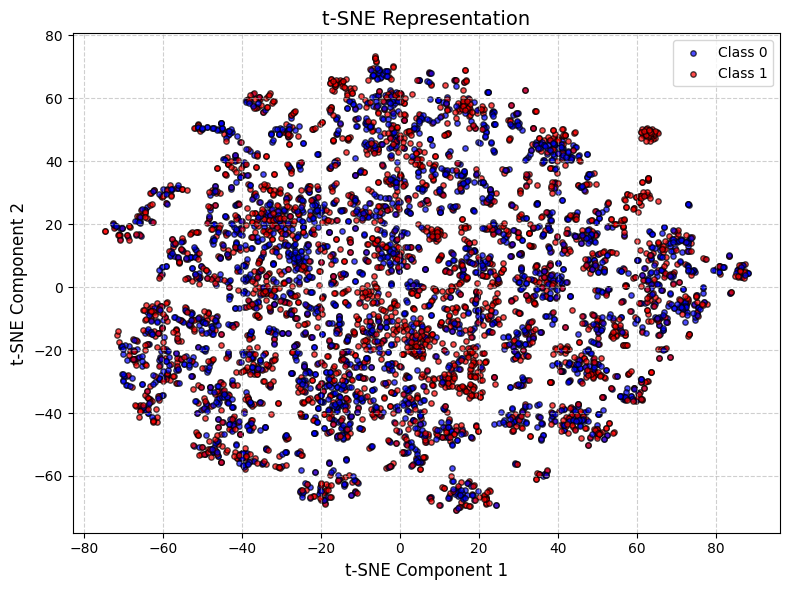

In [76]:
# tsne

X_2d = apply_tsne_to_numpy(X_train_ae)
plot_tsne(X_2d, y_train)

In [77]:
experiments(X_train_ae, y_train, X_test_ae, y_test, dataset_train_path)

  0%|          | 0/31 [00:00<?, ?it/s]

 97%|█████████▋| 30/31 [01:27<00:01,  1.21s/it]

[LightGBM] [Info] Number of positive: 2723, number of negative: 2777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495091 -> initscore=-0.019637
[LightGBM] [Info] Start training from score -0.019637


100%|██████████| 31/31 [01:27<00:00,  2.83s/it]

Predictions saved to data/04-clustering/spanish-chunks-openai/clf_models.csv
##################################################
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.74               0.74     0.74      0.74   
NuSVC                       0.73               0.73     0.73      0.73   
LGBMClassifier              0.71               0.70     0.70      0.71   
RandomForestClassifier      0.70               0.70     0.70      0.70   
CalibratedClassifierCV      0.70               0.69     0.69      0.70   

                        Time Taken  
Model                               
SVC                           3.27  
NuSVC                         3.70  
LGBMClassifier                0.63  
RandomForestClassifier        8.31  
CalibratedClassifierCV       21.71  


In [74]:
base_classifiers = [
    ("nusvc", NuSVC()),
    ("svc", SVC()),
    ("lgbm", LGBMClassifier(n_jobs=-1)),
    ("xgb", XGBClassifier()),
    ("randomforest", RandomForestClassifier(n_jobs=-1)),
]


experiments_stacking(X_train_ae, y_train, X_test_ae, y_test, base_classifiers)

[LightGBM] [Info] Number of positive: 2723, number of negative: 2777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495091 -> initscore=-0.019637
[LightGBM] [Info] Start training from score -0.019637
[LightGBM] [Info] Number of positive: 2178, number of negative: 2222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 4400, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [

## Chunks MNLI

In [67]:
dataset_train_path = "data/04-clustering/spanish-chunks-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-chunks-sentence-transformers/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

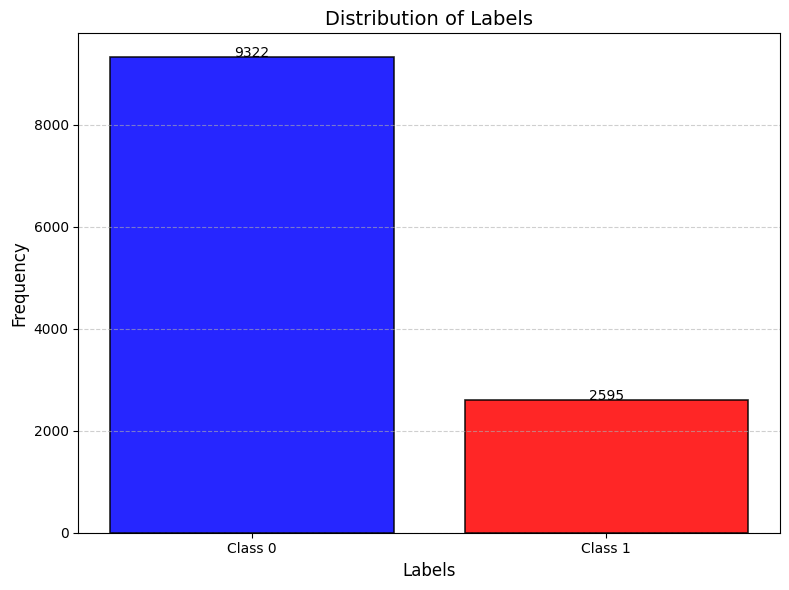

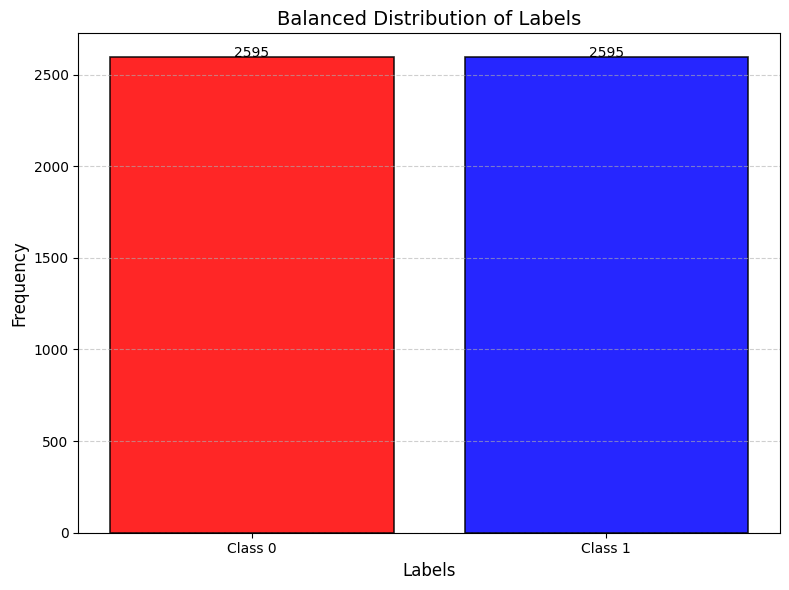

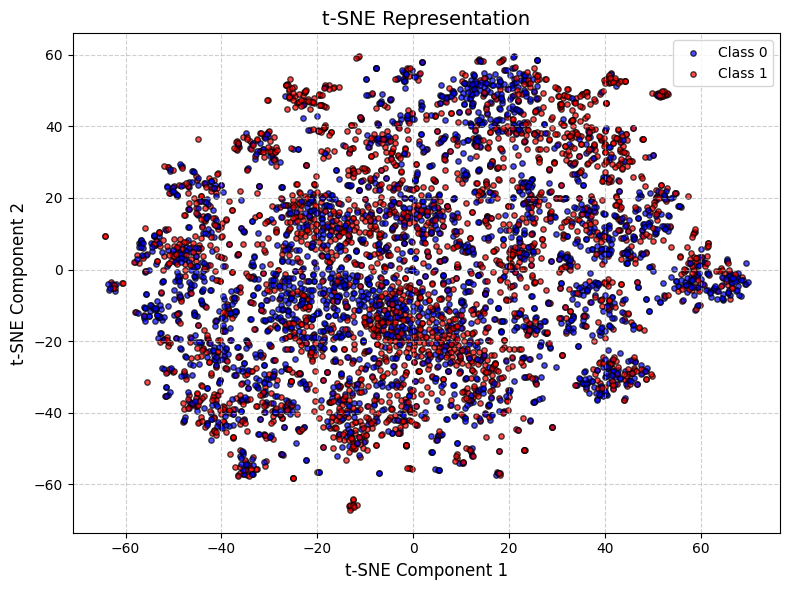

 97%|█████████▋| 30/31 [01:51<00:01,  1.88s/it]

[LightGBM] [Info] Number of positive: 2595, number of negative: 2595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5190, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 31/31 [01:52<00:00,  3.64s/it]

Predictions saved to data/04-clustering/spanish-chunks-sentence-transformers/clf_models.csv
##################################################
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.63               0.68     0.68      0.65   
ExtraTreesClassifier               0.64               0.68     0.68      0.67   
QuadraticDiscriminantAnalysis      0.63               0.67     0.67      0.65   
RandomForestClassifier             0.65               0.67     0.67      0.67   
LGBMClassifier                     0.63               0.67     0.67      0.65   

                               Time Taken  
Model                                      
SVC                                  6.87  
ExtraTreesClassifier                 1.46  
QuadraticDiscriminantAnalysis        0.48  
RandomForestClassifier               9.64  
LGBMClassifier           

In [68]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-paragraphs-openai

In [69]:
dataset_train_path = "data/04-clustering/spanish-paragraphs-openai/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-paragraphs-openai/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

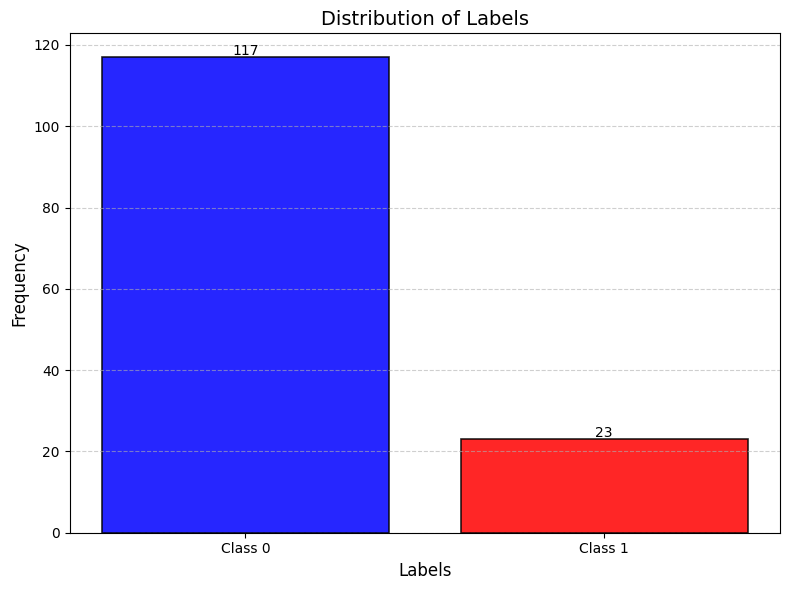

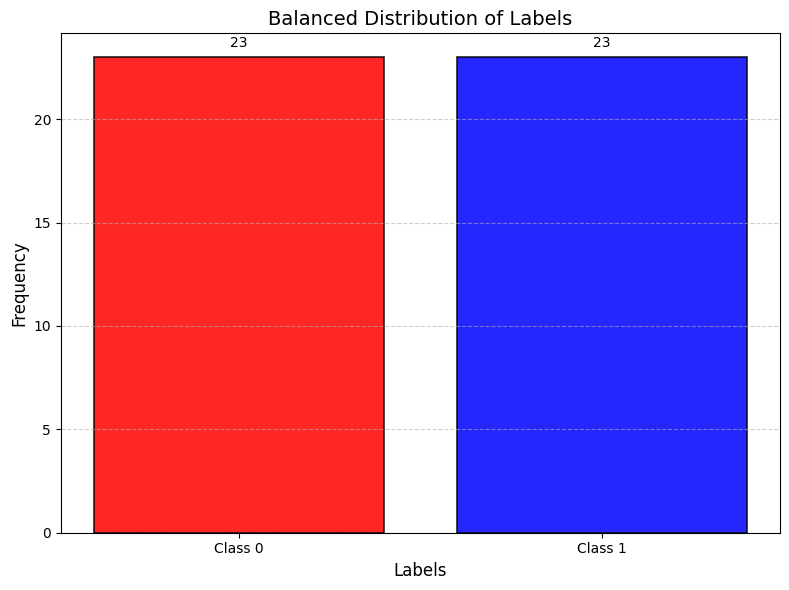

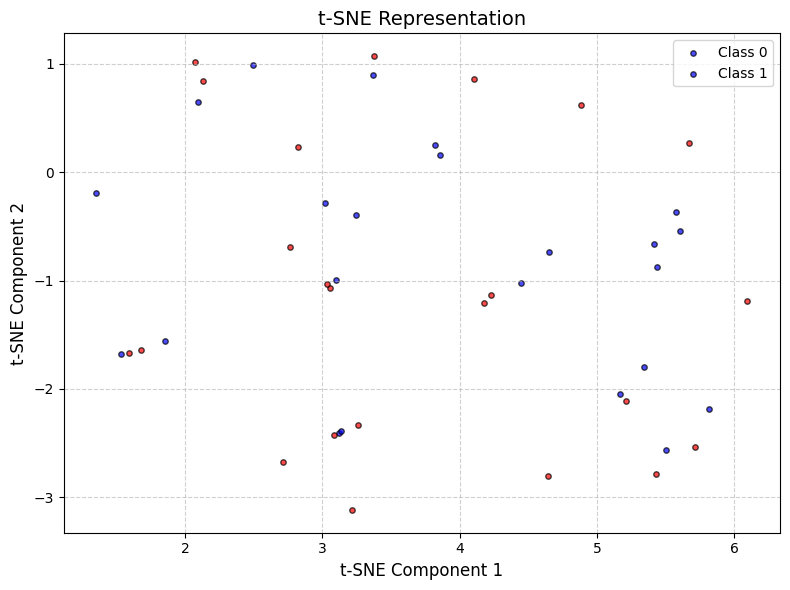

100%|██████████| 31/31 [00:02<00:00, 13.21it/s]

[LightGBM] [Info] Number of positive: 23, number of negative: 23
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 3072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [200]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-paragraphs-sentence-transformers

In [201]:
dataset_train_path = "data/04-clustering/spanish-paragraphs-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-paragraphs-sentence-transformers/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

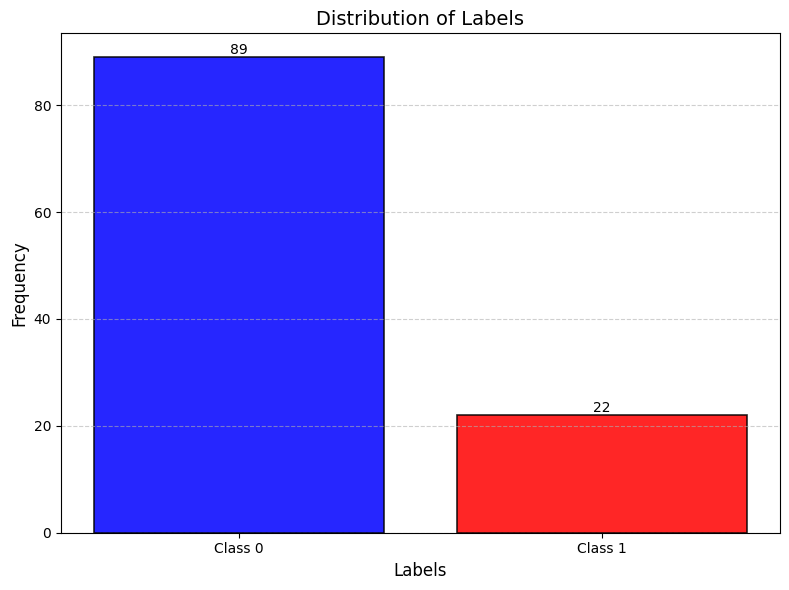

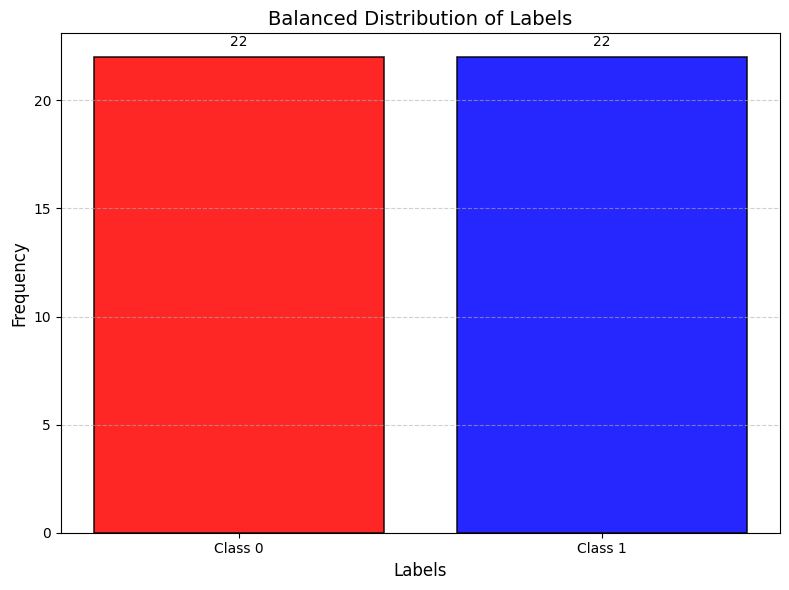

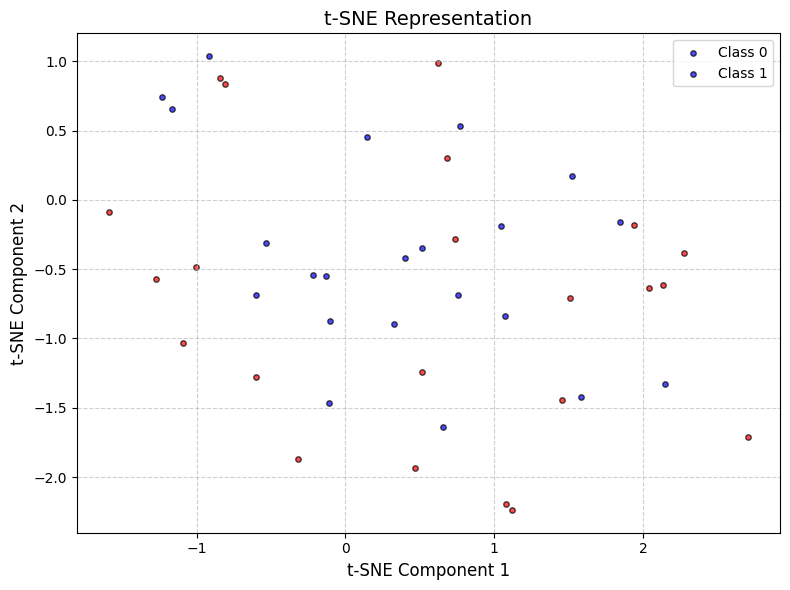

100%|██████████| 31/31 [00:01<00:00, 25.16it/s]

[LightGBM] [Info] Number of positive: 22, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12532
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [202]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-sentences-openai

In [70]:
dataset_train_path = "data/04-clustering/spanish-sentences-openai/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-sentences-openai/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

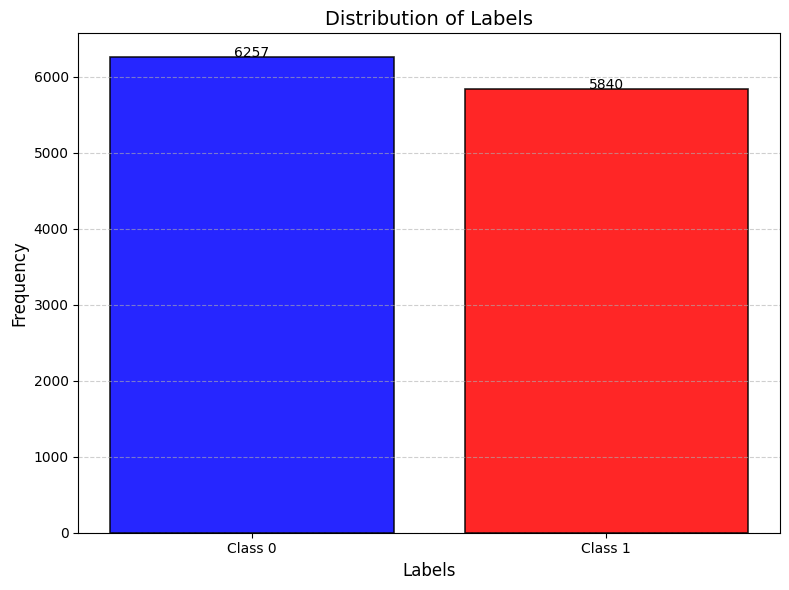

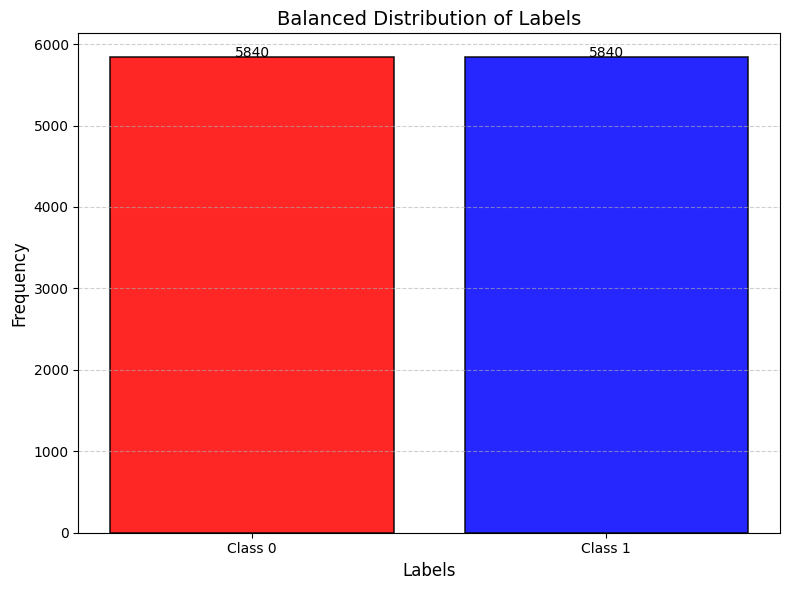

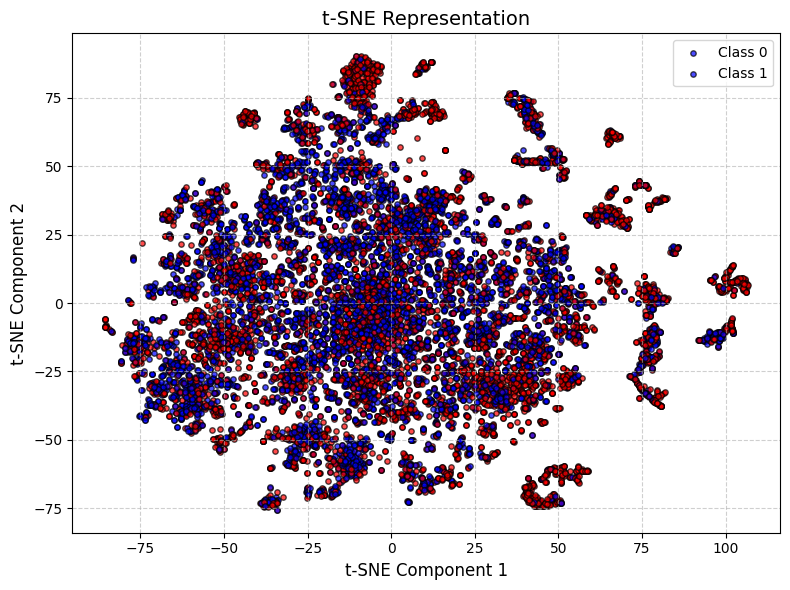

  3%|▎         | 1/31 [03:05<1:32:52, 185.76s/it]

In [ ]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-sentences-sentence-transformers

In [205]:
dataset_train_path = "data/04-clustering/spanish-sentences-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-sentences-sentence-transformers/clustring_embedding_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

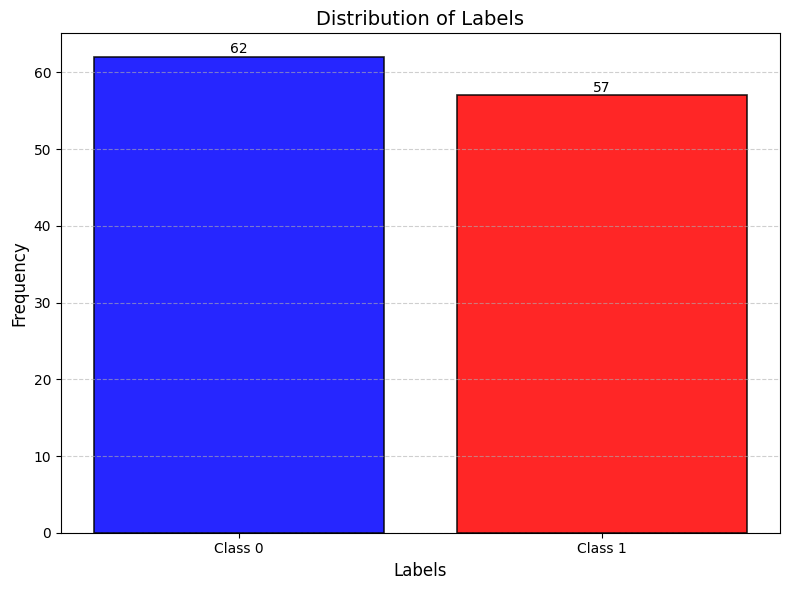

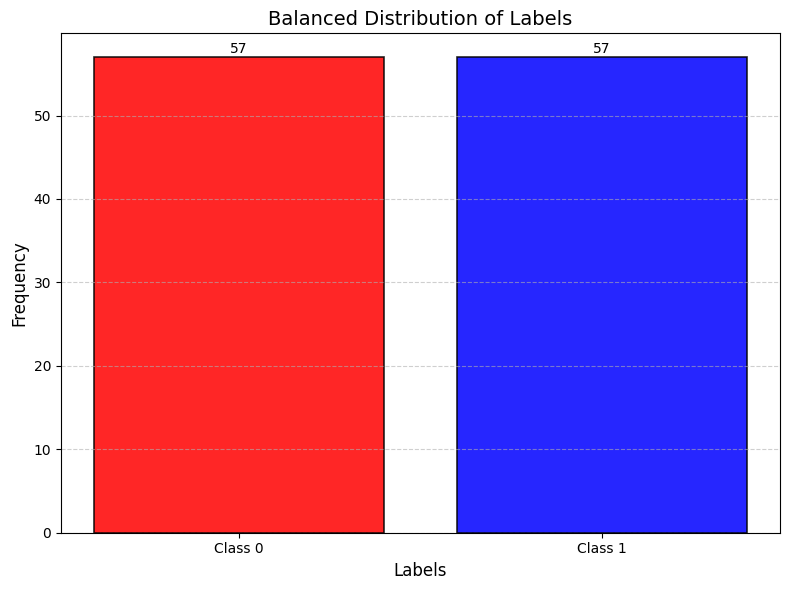

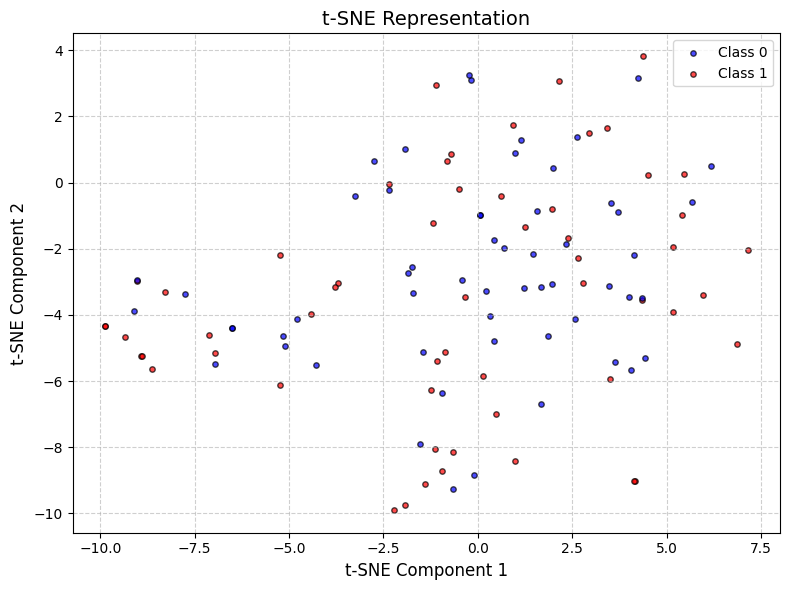

100%|██████████| 31/31 [00:02<00:00, 15.05it/s]

[LightGBM] [Info] Number of positive: 57, number of negative: 57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30442
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [206]:
experiments(dataset_train, dataset_test, dataset_train_path)